## Redes Neuronales - TP N°3

### Cargado de datos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

# Se dejaron estos imports porque, de las redes con las que se probó, DenseNet201 fue la segunda mejor en resultados.
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet201

from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_input_resnet152

In [3]:
base_path = "drive/MyDrive/Redes Neuronales/TP3/rn2021q1itba-cifar100/"
x_train_val = np.load(base_path + "x_train.npy")
x_test = np.load(base_path + "x_test.npy")
y_train_val = np.load(base_path + "y_train.npy")

In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, 
    test_size = 0.15, 
    random_state = 9, 
    stratify = y_train_val
)

### Entrenamiento

In [5]:
batch_size = 256

# Número de epochs grande -- En general se corta por EarlyStopping.
epochs = 100
metrics = ['accuracy']
val_metric = 'val_accuracy'

# Función de costo: categorical crossentropy.
loss = 'categorical_crossentropy'

# EarlyStopping con monitoreo de métrica de validación.
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 15, monitor = val_metric)
save_path = "drive/MyDrive/Redes Neuronales/TP3/Model_Checkpoint_resnet152/weights_resnet152.ckpt"

# ModelCheckpoint con monitoreo de métrica de validación.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor = val_metric, 
    filepath = save_path, 
    save_best_only = True, 
    mode = 'max', 
    save_weights_only = True
)

Entrenamiento en múltiples etapas:

- Primero, optimizador Adam y $\textit{learning_rate}$ de $1 \cdot 10^{-3}$.
- Luego, cambiando el learning_rate a $0.1 \cdot 10^{-3}$.
- Cuando se estabiliza, cambiamos a optimizador SGD con $\textit{learning_rate}$ $0.5 \cdot 10^{-3}$.
- Finalmente, sacamos la capa de $\textit{DropOut}$ y cambiamos el $\textit{learning_rate}$ a $0.1 \cdot 10^{-3}$.

También fuimos modificando los parámetros de data augmentation, de forma tal de que vayan bajando a medida que la métrica de validación se empieza a estabilizar. Se encontró que esta práctica daba buenos resultados.

In [6]:
size = (224, 224)

# Data Augmentation
data_aug = tf.keras.models.Sequential(
    [
        #preprocessing.RandomRotation(factor=0.1),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(mode = 'horizontal'),
        #preprocessing.RandomZoom(.1, .1)
        #preprocessing.RandomContrast(factor=0.1),
     
    ]
)

# Capa de reprocess input para ResNet152
class PreprocLayer(tf.keras.layers.Layer):
    def __init__(self):
      super().__init__()

    def call(self, in_img):
      return preprocess_input_resnet152(in_img)


# Capa de input
inp = layers.Input(shape = x_train.shape[1:])

# Capa de resizing y preprocesado -- Llevamos la imagen a 224x224x3 y 
# le aplicamos función de preprocesamiento de ResNet152.
pad = PreprocLayer()(preprocessing.Resizing(*size)(inp))
x = data_aug(pad)

# Red ResNet152 con pre-entrenamiento de ImageNet
net = ResNet152(input_tensor = x, include_top = False, weights = 'imagenet')

# Congelado de pesos pre-entrenados de ResNet152
net.trainable = False

# Agregamos capa de GlobalAveragePooling2D y BatchNormalization
x = layers.GlobalAveragePooling2D()(net.output)
x = layers.BatchNormalization()(x)

# Capa de DropOut (con porcentaje a modificar según la etapa de entrenamiento)
x = layers.Dropout(0.2)(x)

# Capa densa de 100 salidas con activación SoftMax. Se probó agregar una capa intermedia con 256 salidas + BatchNormalization 
# previa a la capa de SoftMax, pero se encontró que no daba mejores resultados.
out = layers.Dense(100, activation = 'softmax')(x)

# Creación del modelo
model = tf.keras.Model(inp, out)

234700800/234698864 [==============================] - 3s 0us/step


In [ ]:
# Cargado de pesos guardados
model.load_weights(save_path)

# Compilación del modelo (con optimizador y learning_rate a modificar según la etapa de entrenamiento).
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss = loss, metrics = metrics)

# Entrenado del modelo.
model.fit(
    x_train, to_categorical(y_train),
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_val, to_categorical(y_val)),
    callbacks = [early_stopping, checkpoint],
    shuffle = True
)

### Métrica final de validación

In [ ]:
# Cargado de pesos con mejores resultados de validación.
model.load_weights(save_path)
model.evaluate(x_val, to_categorical(y_val))

235/235 [==============================] - 83s 208ms/step - loss: 0.8970 - accuracy: 0.7737


[0.8970157504081726, 0.7737333178520203]

### Predicción de test

In [ ]:
df = pd.DataFrame(model.predict(x_test, verbose = 1).argmax(axis = -1), columns = ['label'])
df.index.name = 'Id'
df.to_csv('drive/MyDrive/Redes Neuronales/TP3/Predictions/submission5.csv')

313/313 [==============================] - 66s 206ms/step


### Anexo: Visualización del modelo

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.655445 to fit



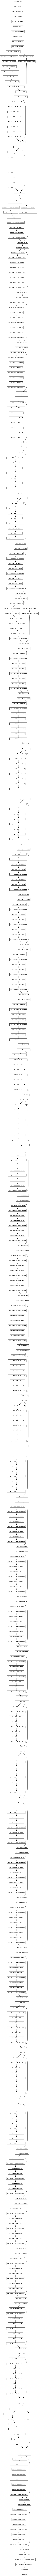

In [7]:
plot_model(model, 'drive/MyDrive/Redes Neuronales/TP3/ModelGraph_ResNet152.png')